# Imaging and deconvolution demonstration For M31 with Accurate Position

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [17]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = '/tmp/'

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt
from astropy.time import Time

from rascil2.data_models import PolarisationFrame

from rascil2.processing_components import create_visibility, create_visibility_from_source, show_image, export_image_to_fits, \
    deconvolve_cube, restore_cube, create_named_configuration, create_test_image, \
    create_image_from_visibility, advise_wide_field, invert_ng, predict_ng, \
    plot_uvcoverage, plot_visibility

from rascil2.processing_components.util import catalog

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 

In [19]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

Construct LOW core configuration

In [20]:
lowr3 = create_named_configuration('LOWBD2', rmax=750.0)
print(lowr3)

create_named_configuration: LOWBD2
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_named_configuration: LOWBD2
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_configuration_from_file: Maximum radius 750.0 m includes 236 antennas/stations
create_configuration_from_file: Maximum radius 750.0 m includes 236 antennas/stations
<xarray.Configuration>
Dimensions:   (id: 236, spatial: 3)
Coordinates:
  * id        (id) int64 0 1 2 3 4 5 6 7 8 ... 228 229 230 231 232 233 234 235
  * spatial   (spatial) <U1 'X' 'Y' 'Z'
Data variables:
    names     (id) <U10 'LOWBD2_0' 'LOWBD2_1' ... 'LOWBD2_270' 'LOWBD2_271'
    xyz       (id, spatial) float64 -1.697e+03 -4.573e+03 .

Use M31 as our object

In [4]:
cat = catalog.CatalogFactory.get_catalog("USER")

source = cat.lookup("M31")
print(source)

rascil2.processing_components.util.catalog.Catalog('USER')
rascil2.processing_components.util.catalog.CatalogEntry('M31',Star(ra=10.684624999999999, dec=41.26927777777777, epoch=2451545.0))


In [5]:
utc_times = Time("2000-01-01T12:00:00.000", format="isot", scale="utc")

# The times are hour angles (default) instead of utc time (in radians)
# 6 hours
utc_time_offset = numpy.array([0.0])

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [6]:
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])

vt = create_visibility_from_source(
    lowr3,
    utc_time_offset,
    frequency,
    channel_bandwidth=channel_bandwidth,
    weight=1.0,
    source=source,
    utc_time=utc_times,
    polarisation_frame=PolarisationFrame('stokesI'),
)

print(vt)

create_visibility: created 1 times
create_visibility: 27966 rows, 0.003 GB
create_visibility_from_source: 27966 rows, 0.003 GB
<xarray.Visibility>
Dimensions:            (time: 1, baselines: 27966, frequency: 1,
                        polarisation: 1, spatial: 3)
Coordinates:
  * time               (time) float64 4.454e+09
  * baselines          (baselines) object MultiIndex
  * antenna1           (baselines) int64 0 0 0 0 0 0 ... 233 233 233 234 234 235
  * antenna2           (baselines) int64 0 1 2 3 4 5 ... 233 234 235 234 235 235
  * frequency          (frequency) float64 1e+08
  * polarisation       (polarisation) <U1 'I'
  * spatial            (spatial) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time) float64 1.0
    datetime           (time) datetime64[ns] 2000-01-02T11:56:20.880647502
    vis                (time, baselines, frequency, polarisation) complex128 ...
    weight             (time, baselines, frequency, polarisation) float64 0.0...
    imaging_weight  

In [7]:
print(vt.phasecentre)

<SkyCoord (ICRS): (ra, dec) in deg
    (10.68245393, 41.27098089)>


In [8]:
advice = advise_wide_field(vt, guard_band_image=3.0, delA=0.1, facets=1, wprojection_planes=1, 
                           oversampling_synthesised_beam=4.0)
cellsize = advice['cellsize']

advise_wide_field: (max_wavelength) Maximum wavelength 2.998 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 2.998 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 393.0 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 393.0 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 35.0 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0857 (rad) 4.91 (deg) 1.77e+04 (asec)
advise_wide_field: (image_fov) Image field of view 0.257 (rad) 14.7 (deg) 5.3e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 0.00254 (rad) 0.146 (deg) 525 (asec)
advise_wide_field: (cellsize) Cellsize 0.000636 (rad) 0.0364 (deg) 131 (asec)

advice_wide_field: (npixels) Npixels per side = 404
advice_wide_field: (npixels2) Npixels (power of 2) per side = 512
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 512
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 512

advice_wide_field: (w_sampling_image) W 

Plot the synthesized uv coverage.

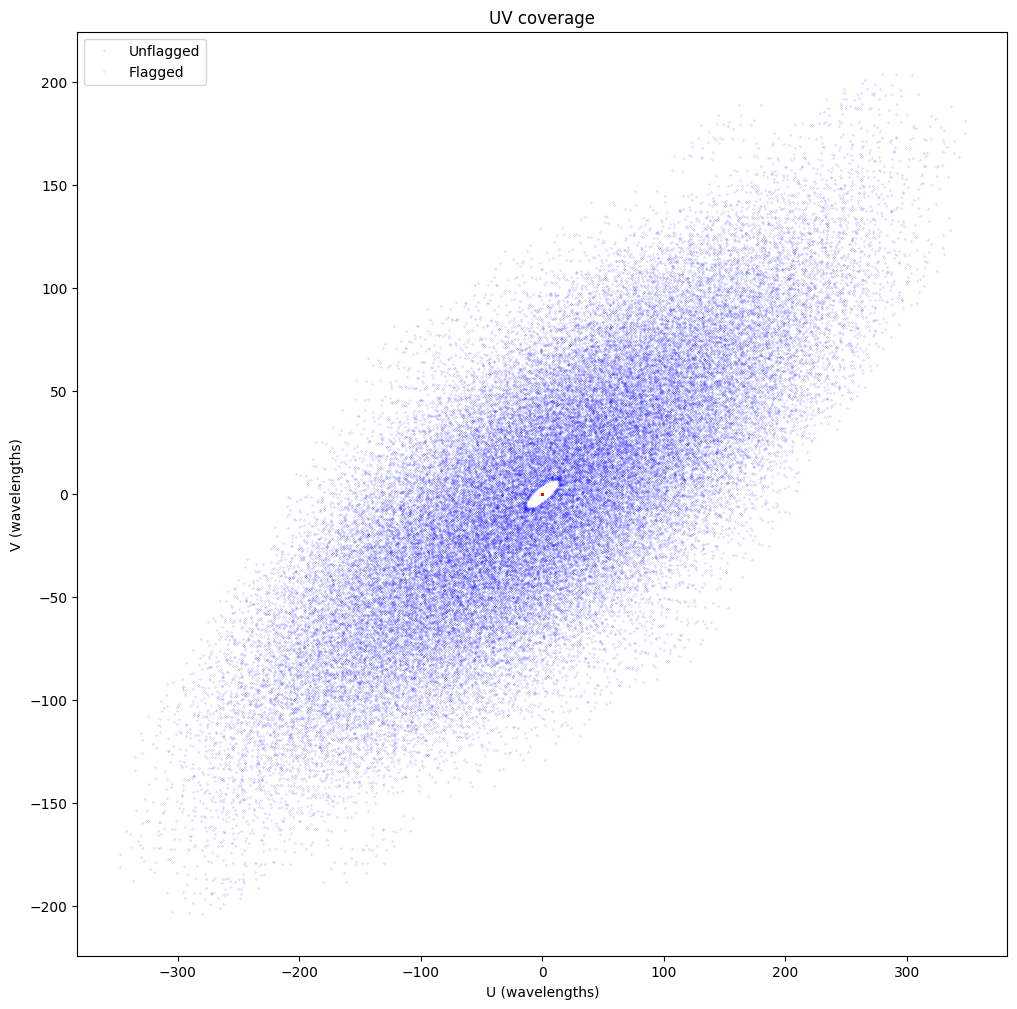

In [9]:
plt.clf()
plot_uvcoverage([vt])
plt.show()

Read the venerable test image, constructing an image

In [10]:
m31image = create_test_image(frequency=frequency, cellsize=cellsize,
                             phasecentre=vt.phasecentre)
nchan, npol, ny, nx = m31image["pixels"].data.shape

fig=show_image(m31image)

print(nchan, npol)

import_image_from_fits: created >f8 image of shape (1, 1, 256, 256)
import_image_from_fits: Max, min in /home/wangfeng/work/rascil2/data/models/M31_canonical.model.fits = 1.006458, 0.000000
replicate_image: replicating shape (1, 1, 256, 256) to (1, 1, 256, 256)
1 1


In [12]:
vt = predict_ng(vt, m31image, context='2d')

plt.clf()
plot_visibility([vt])
plt.show()

Make the dirty image and point spread function

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (10.68245393, 41.27098089)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 347.726866 wavelengths
create_image_from_visibility: Critical cellsize = 0.001438 radians, 0.082386 degrees
create_image_from_visibility: Cellsize          = 0.000636124 radians, 0.0364472 degrees
create_image_from_visibility: image shape is [1, 1, 512, 512]
Max, min in dirty image = 38.564914, -4.316561, sumwt = 27730.000000
Max, min in PSF         = 1.000000, -0.004361, sumwt = 27730.000000


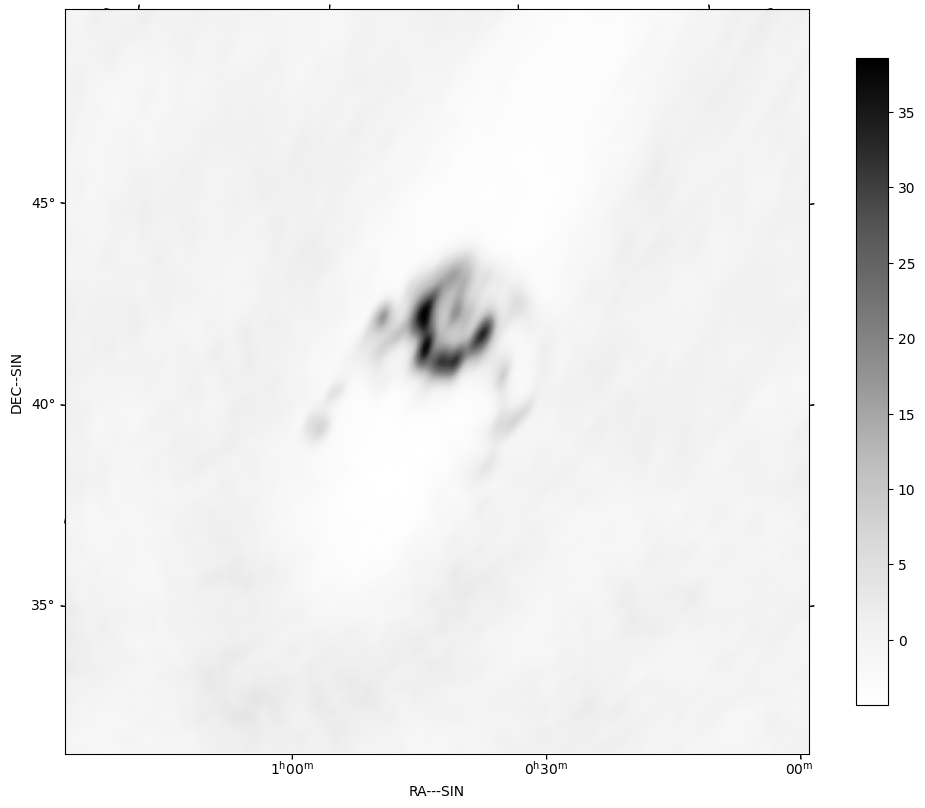

In [13]:
model = create_image_from_visibility(vt, cellsize=cellsize, npixel=512)
dirty, sumwt = invert_ng(vt, model, context='2d')
psf, sumwt = invert_ng(vt, model, context='2d', dopsf=True)

show_image(dirty)
print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty["pixels"].data.max(), dirty["pixels"].data.min(), sumwt))

print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf["pixels"].data.max(), psf["pixels"].data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging_dirty.fits'%(results_dir))
export_image_to_fits(psf, '%s/imaging_psf.fits'%(results_dir))

Deconvolve using clean

deconvolve_cube : window is inner quarter
deconvolve_cube : Cleaning inner quarter of each sky plane
deconvolve_cube : PSF support = +/- 256 pixels
deconvolve_cube : PSF shape (1, 1, 512, 512)
msclean_kernel_list : Starting Multi-scale clean of each polarisation and channel separately
msclean_kernel_list : Processing pol 0, channel 0
msclean : Peak of PSF = 1.0000000000000082 at (256, 256)
msclean : Peak of Dirty = 38.564914 Jy/beam at (301, 247) 
msclean : Coupling matrix =
 [[1.         0.98370118 0.79028764 0.33412798]
 [0.98370118 0.96802519 0.78114896 0.33296247]
 [0.79028764 0.78114896 0.6652531  0.31612001]
 [0.33412798 0.33296247 0.31612001 0.21904329]]
msclean : Max abs in dirty Image = 38.564914 Jy/beam
msclean : Start of minor cycle
msclean : This minor cycle will stop at 10000 iterations or peak < 0.038565 (Jy/beam)
msclean : Timing for setup: 0.512 (s) for dirty shape (512, 512), PSF shape (512, 512) , scales [0, 3, 10, 30]
msclean : Minor cycle 0, peak [38.3654369  38.301

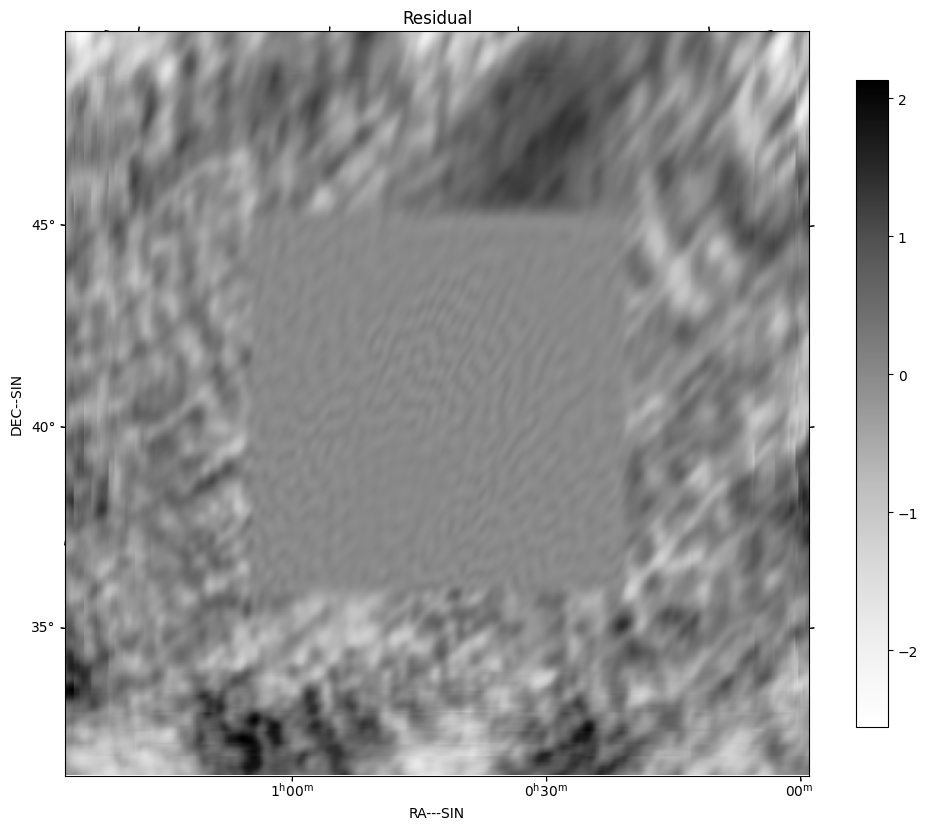

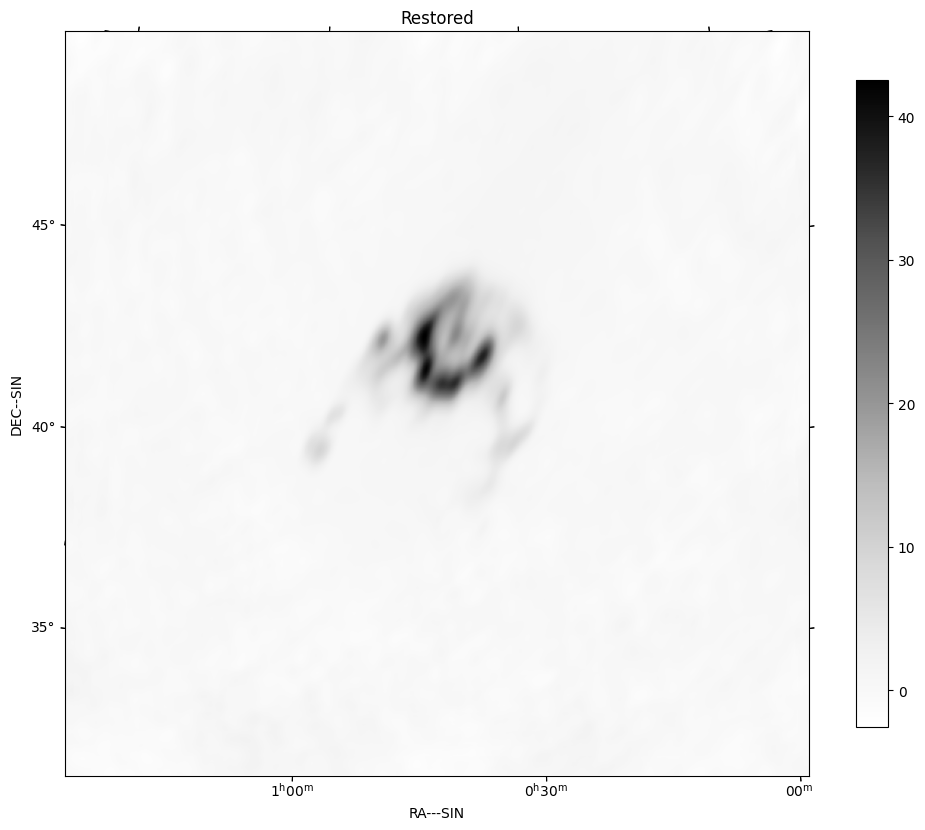

In [14]:
comp, residual = deconvolve_cube(dirty, psf, niter=10000, threshold=0.001, fractional_threshold=0.001,
                                 window_shape='quarter', gain=0.7, scales=[0, 3, 10, 30])

restored = restore_cube(comp, psf, residual)

# Show the results

fig=show_image(comp)
plt.title('Solution')
fig=show_image(residual)
plt.title('Residual')
fig=show_image(restored)
plt.title('Restored')

print(restored)

Predict the visibility of the model

In [21]:
vtmodel = create_visibility_from_source(
    lowr3,
    utc_time_offset,
    frequency,
    channel_bandwidth=channel_bandwidth,
    weight=1.0,
    source=source,
    utc_time=utc_times,
    polarisation_frame=PolarisationFrame('stokesI'),
)

vtmodel=predict_ng(vtmodel, comp, context='2d')

create_visibility: created 1 times
create_visibility: created 1 times
create_visibility: 27966 rows, 0.003 GB
create_visibility: 27966 rows, 0.003 GB
create_visibility_from_source: 27966 rows, 0.003 GB
create_visibility_from_source: 27966 rows, 0.003 GB


Now we will plot the original visibility and the residual visibility.

In [22]:
vtmodel.vis.values = vt.vis.values - vtmodel.vis.values

plt.clf()
plot_visibility([vt, vtmodel], colors=['b', 'r'])
plt.show()